### First bring in the necessary import statements to eda and initial modeling to examine the data.

In [41]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import pos_tag, FreqDist
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.manifold import TSNE
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from nltk.corpus import stopwords, wordnet
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from nltk.tokenize import word_tokenize, regexp_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, precision_score

import os
import sys
sys.setrecursionlimit(100000)
module_path = os.path.abspath(os.pardir)
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline
pd.set_option('display.max_colwidth', None)

/Users/jax/Documents/Flatiron


### Bring in the data and examine the head and tail of the set.

In [2]:
org_df = pd.read_csv('data/GW_Sentiment_Tweets.csv')

In [3]:
org_df.count()

tweet                   6027
existence               4187
existence_confidence    6024
dtype: int64

In [4]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6027 entries, 0 to 6026
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet                 6027 non-null   object 
 1   existence             4187 non-null   object 
 2   existence_confidence  6024 non-null   float64
dtypes: float64(1), object(2)
memory usage: 141.4+ KB


In [5]:
org_df

,tweet,existence,existence_confidence
0,"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",Yes,1.0000
1,Fighting poverty and global warming in Africa [link],Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],Yes,0.8087
...,...,...,...
6022,"@bloodless_coup ""The phrase 'global warming' should be abandoned in favor of 'climate change', Luntz says,"" http://bit.ly/7bIY0c #p2 #tcot",Y,1.0000
6023,Virginia to Investigate Global Warming Scientist Mann: http://bit.ly/aDlavg,NaN,1.0000
6024,Global warming you tube parody you will enjoy #IPCC #ocra http://bit.ly/bBGWhC,N,0.6411
6025,One-Eyed Golfer: Don't dare tell me about global warming: Twenty-five of the forty-nine golfers making the cut thi... http://bit.ly/akeAxp,N,1.0000


### From here you can already see there are duplicate rows of tweets strangely with different existence values.

In [6]:
num_unique = (~org_df.tweet.duplicated()).sum()
num_unique

5481

In [7]:
num_duplicate = org_df.tweet.duplicated().sum()
num_duplicate

546

### There are 5481 tweets that are not duplicates. Let's extract the duplicate rows.

In [8]:
org_df.loc[org_df.tweet.duplicated(), :]

,tweet,existence,existence_confidence
3,Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,1.0000
94,"Plants effective way of tackling global warming|Washington, Apr 30 : Plant leaves account for less than one per .. [link]",Yes,0.7925
111,"CLIMATE CHANGE: Forests Not for Absorbing Carbon, Say Activists [link]",NaN,0.6135
112,"CLIMATE CHANGE: Forests Not for Absorbing Carbon, Say Activists [link]",Yes,0.5763
114,"CLIMATE CHANGE: Forests Not for Absorbing Carbon, Say Activists [link]",Yes,0.8243
...,...,...,...
5840,"Global warming ballot initiative: Teamsters and cities weigh in: The California Teamsters, one of the state's most... http://bit.ly/aMYbOS",NaN,0.6346
5903,"http://theclimatedesk.org/ launches, backed by Wired, Atlantic, Mother Jones, Slate, CIR, NPR, to report climate change impacts, responses",Y,0.6424
5999,Natural Resource Econ: Krugman on Climate Change http://bit.ly/b4IyRj,Y,0.6436
6003,"Valero Gas wants to kill AB 32, CA's global warming law. Join @CredoAction & @CourageCampaign to stop them: http://BoycottValero.com Pls RT",NaN,0.7674


In [9]:
unique_df=org_df.drop_duplicates(subset='tweet', keep='first').copy()

In [10]:
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5481 entries, 0 to 6026
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet                 5481 non-null   object 
 1   existence             3822 non-null   object 
 2   existence_confidence  5478 non-null   float64
dtypes: float64(1), object(2)
memory usage: 171.3+ KB


### Now all our duplicates have been removed and we can continue onto our preprocessing of the tweets. First let's create our target.

In [11]:
le = LabelEncoder()
le.fit(unique_df['existence'])
unique_df['target'] = le.transform(unique_df['existence'])
unique_df.target.value_counts()

2    2371
4    1659
0     981
3     429
1      41
Name: target, dtype: int64

### Well crap. Got 5 different classes for some odd reason so let's further analyze.

In [12]:
unique_df.existence.value_counts()

Y      2371
N       981
Yes     429
No       41
Name: existence, dtype: int64

### Strangely we have Y, Yes and N, No so let's consolodate those.

In [13]:
unique_df.replace('Y', 'Yes', inplace=True)
unique_df.replace('N', 'No', inplace=True)
unique_df.existence.value_counts()

Yes    2800
No     1022
Name: existence, dtype: int64

In [14]:
le.fit(unique_df['existence'])
unique_df['target'] = le.transform(unique_df['existence'])
unique_df.target.value_counts()

1    2800
2    1659
0    1022
Name: target, dtype: int64

### There we go that's better so now we can drop the column existence.

In [15]:
unique_df.drop(columns=['existence'], axis=1, inplace=True)
unique_df.drop(columns=['tweet'], axis=1, inplace=True)
unique_df

,tweet,existence_confidence,target
0,"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",1.0000,1
1,Fighting poverty and global warming in Africa [link],1.0000,1
2,Carbon offsets: How a Vatican forest failed to reduce global warming [link],0.8786,1
4,URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],0.8087,1
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle [link],1.0000,1
...,...,...,...
6022,"@bloodless_coup ""The phrase 'global warming' should be abandoned in favor of 'climate change', Luntz says,"" http://bit.ly/7bIY0c #p2 #tcot",1.0000,1
6023,Virginia to Investigate Global Warming Scientist Mann: http://bit.ly/aDlavg,1.0000,2
6024,Global warming you tube parody you will enjoy #IPCC #ocra http://bit.ly/bBGWhC,0.6411,0
6025,One-Eyed Golfer: Don't dare tell me about global warming: Twenty-five of the forty-nine golfers making the cut thi... http://bit.ly/akeAxp,1.0000,0


### Now let's remove punctuation and numerals. Then stop words and tokenize.

In [16]:
#Function to clean tweets
def clean_tweet(tweet):
    tweet_unlink= re.sub(r"http\S+",' ', tweet)
    # remove numbers re.sub(pattern, repl, string, count=0, flags=0)
    tweet_nonum = re.sub(r'\d+', ' ', tweet_unlink)
    # remove punctuations and lower case
    tweet_nopunct = ''.join([char.lower() for char in tweet_nonum if char not in string.punctuation])
    # substitute multiple whitespace with single whitespace
    cleaned_tweet = re.sub('\s+',' ', tweet_nopunct).strip()
    return cleaned_tweet

In [17]:
#Apply cleaning function to all tweets
unique_df['new_tweets']= unique_df['tweet'].apply(clean_tweet)

In [18]:
#Instatiate tokenizer object and tokenize
tt = TweetTokenizer(strip_handles=True)
unique_df['new_tweets']= unique_df['new_tweets'].apply(tt.tokenize)

In [19]:
cust_sw = stopwords.words('english').extend('link')
cv = CountVectorizer(stop_words=cust_sw)
sample = pd.DataFrame(pdt_items['A']+','+pdt_items['B']+','+pdt_items['C'].astype('str'), columns=['Output'])
#unique_df['new_tweets'] = unique_df['new_tweets'].apply(cv.fit_transform)

### Now let's look at NaN values in our existence column. They mean that the tweet is not climate change related.

In [25]:
unique_df.target.value_counts(normalize=True)

1    0.510856
2    0.302682
0    0.186462
Name: target, dtype: float64

In [21]:
unique_df

,tweet,existence_confidence,target,new_tweets
0,"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",1.0000,1,"[global, warming, report, urges, governments, to, actbrussels, belgium, ap, the, world, faces, increased, hunger, and, link]"
1,Fighting poverty and global warming in Africa [link],1.0000,1,"[fighting, poverty, and, global, warming, in, africa, link]"
2,Carbon offsets: How a Vatican forest failed to reduce global warming [link],0.8786,1,"[carbon, offsets, how, a, vatican, forest, failed, to, reduce, global, warming, link]"
4,URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],0.8087,1,"[uruguay, tools, needed, for, those, most, vulnerable, to, climate, change, link]"
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle [link],1.0000,1,"[rt, sejorg, rt, jaymiheimbuch, ocean, saltiness, shows, global, warming, is, intensifying, our, water, cycle, link]"
...,...,...,...,...
6022,"@bloodless_coup ""The phrase 'global warming' should be abandoned in favor of 'climate change', Luntz says,"" http://bit.ly/7bIY0c #p2 #tcot",1.0000,1,"[bloodlesscoup, the, phrase, global, warming, should, be, abandoned, in, favor, of, climate, change, luntz, says, p, tcot]"
6023,Virginia to Investigate Global Warming Scientist Mann: http://bit.ly/aDlavg,1.0000,2,"[virginia, to, investigate, global, warming, scientist, mann]"
6024,Global warming you tube parody you will enjoy #IPCC #ocra http://bit.ly/bBGWhC,0.6411,0,"[global, warming, you, tube, parody, you, will, enjoy, ipcc, ocra]"
6025,One-Eyed Golfer: Don't dare tell me about global warming: Twenty-five of the forty-nine golfers making the cut thi... http://bit.ly/akeAxp,1.0000,0,"[oneeyed, golfer, dont, dare, tell, me, about, global, warming, twentyfive, of, the, fortynine, golfers, making, the, cut, thi]"


In [43]:
data_pos = unique_df['new_tweets'].loc[unique_df['target'] == 1]
data_na = unique_df['new_tweets'].loc[unique_df['target'] == 2]
data_neg = unique_df['new_tweets'].loc[unique_df['target'] == 0]


disbeliever = []
for i in data_neg:
    ToStr = ' '.join(map(str, i))
    disbeliever.append(ToStr)
disbeliever = ' '.join(map(str, disbeliever))

believer =[]
for i in data_pos:
    ToStr = ' '.join(map(str, i))
    believer.append(ToStr)
believer = ' '.join(map(str, believer))

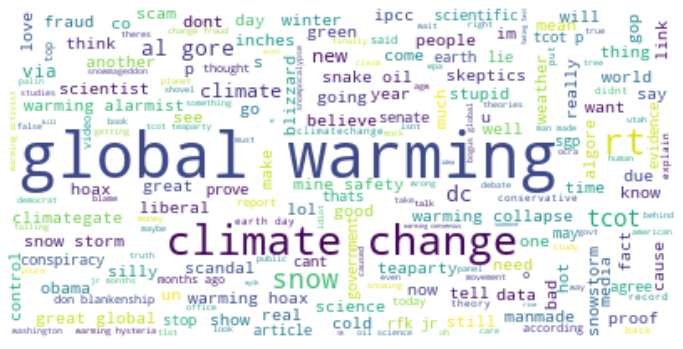

In [35]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays


# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=200,
)
# generate the word cloud
wc.generate(disbeliever)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

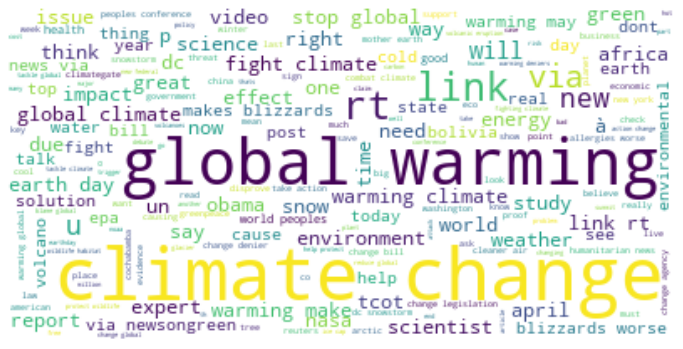

In [44]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
# generate the word cloud
wc.generate(believer)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [42]:

example_freq_dist = FreqDist(unique_df.iloc[100]['new_tweets'][:20])
example_freq_dist

FreqDist({'that': 2, 'so': 1, 'far': 1, 'in': 1, 'class': 1, 'i': 1, 'have': 1, 'gotten': 1, 'into': 1, 'heated': 1, ...})

In [39]:
X = unique_df.drop('tweet', axis=1).copy()

In [40]:
y = unique_df['target'].copy()
X = X.drop('target', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
model=MultinomialNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(accuracy_score(y_test,y_pred))
#print(X_train.toarray()[:2])

ValueError: setting an array element with a sequence.